<a href="https://colab.research.google.com/github/DylanMCullifer/NetworkScienceProject/blob/main/Final_Project_NS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyzing Congressional Political Polarization 2018-2022
Dylan Cullifer/ /

## Sentence Transformer

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random, time
import sklearn
import scipy
import pandas as pd
from sentence_transformers import SentenceTransformer

# Read in all the data for the candidates
biographical_narratives = pd.read_csv("https://raw.githubusercontent.com/nurfnick/NetworkScience/refs/heads/main/Project/biographical_narratives.csv")
policy_platforms = pd.read_csv("https://raw.githubusercontent.com/nurfnick/NetworkScience/refs/heads/main/Project/policy_platforms.csv")
policy_platforms_aggregated = pd.read_csv("https://raw.githubusercontent.com/nurfnick/NetworkScience/refs/heads/main/Project/policy_platforms_aggregated.csv")

merge_cols = ["candidate_webname","state_postal","cd","year","cand_party"]

# drop all entries that lack key values needed
clean_bio = biographical_narratives.dropna(subset=merge_cols)
clean_policy = policy_platforms.dropna(subset=merge_cols)
clean_policy_agg = policy_platforms_aggregated.dropna(subset=merge_cols)

# removed weird starting index column that isn't needed
clean_bio = clean_bio.drop(clean_bio.columns[0], axis=1)
clean_policy = clean_policy.drop(clean_policy.columns[0], axis=1)

# these cols appear in both but are the same so I drop them for an easy merge
drop_duplicate_cols = ["primary_type","dem_prez_vote","inc","quality_cand","win_primary","primary_pct","win_general","general_pct","FECCandID","BIOGUIDE_id"]
bio_no_dups = clean_bio.drop(columns=drop_duplicate_cols)

all_data = clean_policy.merge(bio_no_dups, on=merge_cols, how="left").merge(clean_policy_agg, on=merge_cols, how="left")

# Condenses data to one candidate row per year with their multiple stances in that year put into a set
varying_cols = all_data.groupby(merge_cols).nunique().gt(1).any()
varying_columns = varying_cols[varying_cols].index.to_list()

consistent_cols = [col for col in all_data.columns if col not in merge_cols and col not in varying_columns]
combined_dict = {col: "first" for col in consistent_cols}
combined_dict.update({col: lambda x: set(x) for col in varying_columns})

all_data = all_data.groupby(merge_cols, as_index=False).agg(combined_dict)

print("Total Candidate data shape:", all_data.shape)

all_data_2018 = all_data[all_data["year"] == 2018]
all_data_2020 = all_data[all_data["year"] == 2020]
all_data_2022 = all_data[all_data["year"] == 2022]

all_data_2018 = all_data_2018.reset_index(drop=True)
all_data_2020 = all_data_2020.reset_index(drop=True)
all_data_2022 = all_data_2022.reset_index(drop=True)

print("2018 Candidate data shape:", all_data_2018.shape)
print("2020 Candidate data shape:", all_data_2020.shape)
print("2022 Candidate data shape:", all_data_2022.shape)

all_data_2020.head()

Total Candidate data shape: (4507, 23)
2018 Candidate data shape: (1499, 23)
2020 Candidate data shape: (1449, 23)
2022 Candidate data shape: (1559, 23)


,candidate_webname,state_postal,cd,year,cand_party,primary_type,dem_prez_vote,inc,quality_cand,win_primary,...,housegov_issue,FECCandID,BIOGUIDE_id,biography_text,housegov_bio,platform_text,issue_header,issue_text,policy_code,statement_id
0,Aaron Godfrey,OH,16,2020,Democrat,Open Primary,42.2,0,0,1,...,0,H8OH16090,None,One of three children in a working-class famil...,0.0,Healthcare: Despite the progress made under th...,"{Healthcare, Seniors, Veterans, Fairness Doctr...",{No one working forty hours a week should earn...,"{Healthcare, Energy and Environment, Defense, ...","{15648, 15649, 15650, 15651, 15652, 15653, 156..."
1,Aaron Hermes,TX,22,2020,Republican,Open Primary,48.9,0,0,0,...,0,H0TX22328,None,MY BACKGROUND\r\r\n-Early Years \r\r\n\r\r\nI ...,0.0,'-Election Integrity: The technology and syste...,"{'-Combatting Human Trafficking, '-Environment...",{Fake News used to be laughed at as a theory b...,"{Immigration, Healthcare, Defense, Energy and ...","{18187, 18188, 18189, 18190, 18191, 18192, 181..."
2,Aaron Scanlan,FL,21,2020,Republican,Closed Primary,58.2,0,0,0,...,0,H0FL21060,None,Aaron Scanlan is a principled conservative wit...,0.0,ECONOMIC DEVELOPMENT: While our economy now is...,"{IMMIGRATION, ECONOMIC DEVELOPMENT, FLORIDA'S ...",{Secure our borders and ensure the immigration...,"{Energy and Environment, Healthcare, Immigrati...","{38040, 38037, 38038, 38039}"
3,Aaron Swisher,ID,2,2020,Democrat,Partially-Closed,36.6,0,0,1,...,0,H8ID02148,None,Aaron Swisher was born and raised in rural Wes...,0.0,MANAGING AND BALANCING THE FEDERAL BUDGET: Bec...,"{REFORMING GOVERNMENT, SECURING QUALITY AND AF...",{As new technology arises that makes energy ch...,"{Healthcare, Energy and Environment, Immigrati...","{41602, 41603, 41604, 41605, 41606, 41607, 416..."
4,Abby Finkenauer,IA,1,2020,Democrat,Open Primary,47.4,1,2,1,...,0,H8IA01094,None,Meet Abby\r\r\n\r\r\nAs the youngest woman eve...,0.0,Creating Jobs and a Strong Economy: As your re...,"{Strengthening Family Farms, Standing with Our...",{It is abundantly clear that our current immig...,"{Healthcare, Energy and Environment, Immigrati...","{13631, 13632, 13633, 13634, 13635, 13636, 136..."


Here we load the csv data into frames for ease of handling. Each of the datasets where merged into a main set with all relavent data with duplicates across them dropped. Then all entries from a candidate from a given year are collapsed into one entry for that year where columns that don't change are one value and columns that do are a set of all their values.

In [3]:
platform_text_2018 = all_data_2018["platform_text"].to_list()
platform_text_2020 = all_data_2020["platform_text"].to_list()
platform_text_2022 = all_data_2022["platform_text"].to_list()

transformer = SentenceTransformer("all-MiniLM-L6-v2")

# turn all stated platforms of each candidate into embeddings so we can compare them
platform_text_embeddings_2018 = transformer.encode(platform_text_2018, convert_to_numpy=True, normalize_embeddings=True, show_progress_bar=True)
platform_text_embeddings_2020 = transformer.encode(platform_text_2020, convert_to_numpy=True, normalize_embeddings=True, show_progress_bar=True)
platform_text_embeddings_2022 = transformer.encode(platform_text_2022, convert_to_numpy=True, normalize_embeddings=True, show_progress_bar=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/47 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Batches:   0%|          | 0/49 [00:00<?, ?it/s]

Using a sentence transformer we can take text and turn each stated platform in a an embedding that represents the meaning. Using these embeddings we can compare all the candidates based their similarity of these embeddings.

I've added a way to save these and then load them as the computation time was too long for my liking.

In [13]:
#np.save('/embedding_file_2018.npy',platform_text_embeddings_2018)
#np.save('/embedding_file_2020.npy',platform_text_embeddings_2020)
#np.save('/embedding_file_2022.npy',platform_text_embeddings_2022)

You can now load these back (or instead of running the above.

## Skip Sentence Transformer

In [23]:
import requests
import numpy as np
import tempfile
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random, time
import sklearn
import scipy
import pandas as pd

l = ["embedding_file_2018.npy","embedding_file_2020.npy","embedding_file_2022.npy"]
urlstub = "https://github.com/nurfnick/NetworkScience/raw/refs/heads/main/Project/"
platform_text_embeddings = []

for file in l:
  url = urlstub + file
  with tempfile.NamedTemporaryFile(delete=True) as temp_file:
    response = requests.get(url, stream=True)
    response.raise_for_status() # Raise an exception for bad status codes
    for chunk in response.iter_content(chunk_size=8192):
      temp_file.write(chunk)
    temp_file.seek(0) # Rewind to the beginning of the file AFTER all chunks are written
    platform_text_embeddings.append(np.load(temp_file)) # Load the array once the file is complete

platform_text_embeddings_2018 = platform_text_embeddings[0]
platform_text_embeddings_2020 = platform_text_embeddings[1]
platform_text_embeddings_2022 = platform_text_embeddings[2]

In [24]:
platform_text_embeddings_2018

array([[-0.03721941,  0.04184014,  0.07115123, ..., -0.06016336,
         0.05189839,  0.04797601],
       [ 0.03626484,  0.0238889 , -0.0512529 , ...,  0.04168224,
         0.05377446,  0.04932696],
       [ 0.01164877, -0.04022797,  0.08239871, ...,  0.04645431,
        -0.1267153 ,  0.00392156],
       ...,
       [-0.00211374,  0.07471664,  0.01043453, ..., -0.08811932,
         0.03625819,  0.07383206],
       [-0.01461367, -0.02094346, -0.01934274, ...,  0.00774604,
         0.00519193, -0.04172401],
       [-0.04477266,  0.00375577,  0.00076316, ..., -0.01743081,
         0.02402168,  0.00046611]], dtype=float32)

## Graph Creation

In [25]:
sim_scores_2018 = sklearn.metrics.pairwise.cosine_similarity(platform_text_embeddings_2018)
sim_scores_2020 = sklearn.metrics.pairwise.cosine_similarity(platform_text_embeddings_2020)
sim_scores_2022 = sklearn.metrics.pairwise.cosine_similarity(platform_text_embeddings_2022)

sim_score_threshold = 0.50

G_2018 = nx.Graph()
G_2020 = nx.Graph()
G_2022 = nx.Graph()

def build_graph(sim, data, graph):
    for index, row in data.iterrows():
        graph.add_node(index,
         candidate_webname=row["candidate_webname"], cand_party=row["cand_party"], state_postal=row["state_postal"],
         cd=row["cd"], inc=row["inc"], primary_type=row["primary_type"])

    for x in range(0, sim.shape[0]):
        sim_row = sim[x]
        sim_row[x] = 0
        top10 = sim_row.argsort()
        # for y in range(x + 1, sim.shape[0]):
        for y in top10:
            edge_weight = sim[x,y]
            if edge_weight >= sim_score_threshold:
                graph.add_edge(x, y, weight=edge_weight)

    return graph

G_2018 = build_graph(sim_scores_2018, all_data_2018, G_2018)
G_2020 = build_graph(sim_scores_2020, all_data_2020, G_2020)
G_2022 = build_graph(sim_scores_2022, all_data_2022, G_2022)

print("Num Nodes 2018:", len(G_2018.nodes))
print("Num Edges 2018:", len(G_2018.edges))
print()
print("Num Nodes 2020:", len(G_2020.nodes))
print("Num Edges 2020:", len(G_2020.edges))
print()
print("Num Nodes 2022:", len(G_2022.nodes))
print("Num Edges 2022:", len(G_2022.edges))

Num Nodes 2018: 1499
Num Edges 2018: 123645

Num Nodes 2020: 1449
Num Edges 2020: 102842

Num Nodes 2022: 1559
Num Edges 2022: 106231


Graphs are made based by adding all candidates then adding edges if their embeddings are similar enough.

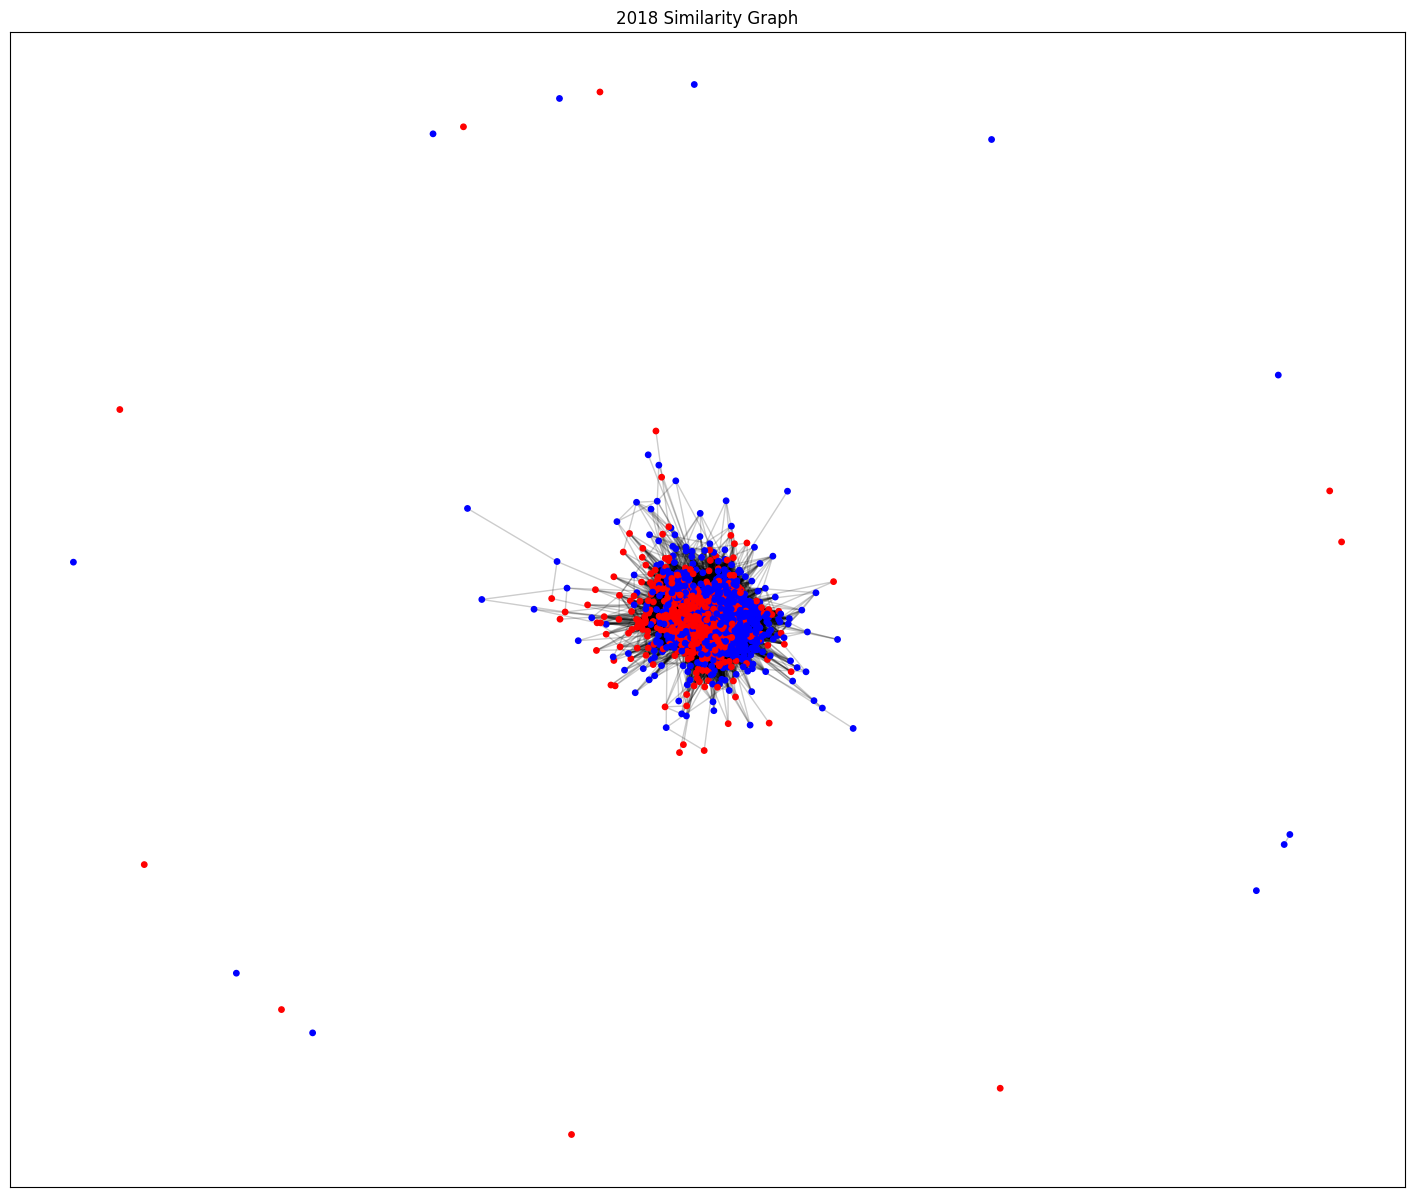

In [27]:
colors = {"Republican": "red", "Democrat": "blue"}

colors_2018 = []
for entry in G_2018.nodes():
    cand_party = G_2018.nodes[entry].get("cand_party")
    if(cand_party != None):
        colors_2018.append(colors[cand_party])
    else:
        colors_2018.append("gray")

plt.close("all")
plt.figure(figsize=(18,15))
position = nx.spring_layout(G_2018, seed=1, k=2, iterations=100, scale=5, weight="sim")
#position = nx.kamada_kawai_layout(G_2018, weight="weight")
nx.draw_networkx_nodes(G_2018, pos=position, node_color=colors_2018, node_size=15)
nx.draw_networkx_edges(G_2018, pos=position, alpha=.2)
plt.title("2018 Similarity Graph")
plt.show()

In [28]:
print(f"Density of Graph edges: { nx.density(G_2018)}")
print(f"Number of components: {nx.number_connected_components(G_2018)}")

Density of Graph edges: 0.11012682242099985
Number of components: 20


In [29]:


# Find the largest connected component
largest_component = max(nx.connected_components(G_2018), key=len)

# Create a subgraph of the largest connected component
subgraph = G_2018.subgraph(largest_component)

# Calculate the diameter of the subgraph
diameter = nx.diameter(subgraph)

print(f"Diameter of the largest connected component: {diameter}")



KeyboardInterrupt: 

<BarContainer object of 706 artists>

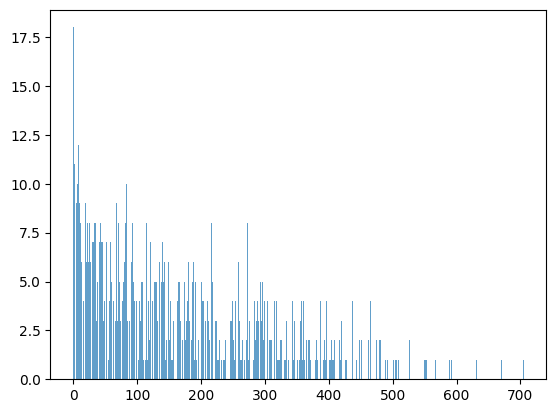

In [30]:
l = [G_2018.degree(u) for u in G_2018.nodes()]

count = [0]*(max(l)+1)
for i in range(max(l)+1):
  count[i] = l.count(i)

plt.bar(range(max(l)+1), count, align='center', alpha=0.7, label='Observed Degree Distribution')

In [31]:


%pip install powerlaw
import powerlaw

fit = powerlaw.Fit(l, discrete=True) # discrete=True for integer degree values
alpha2 = fit.power_law.alpha
xmin = fit.power_law.xmin

R, p = fit.distribution_compare('power_law', 'lognormal')
print(f"Power-law vs Lognormal: R={R}, p={p}")

Calculating best minimal value for power law fit
Power-law vs Lognormal: R=-6.0415772179284275, p=0.03867446692729309


Values less than or equal to 0 in data. Throwing out 0 or negative values


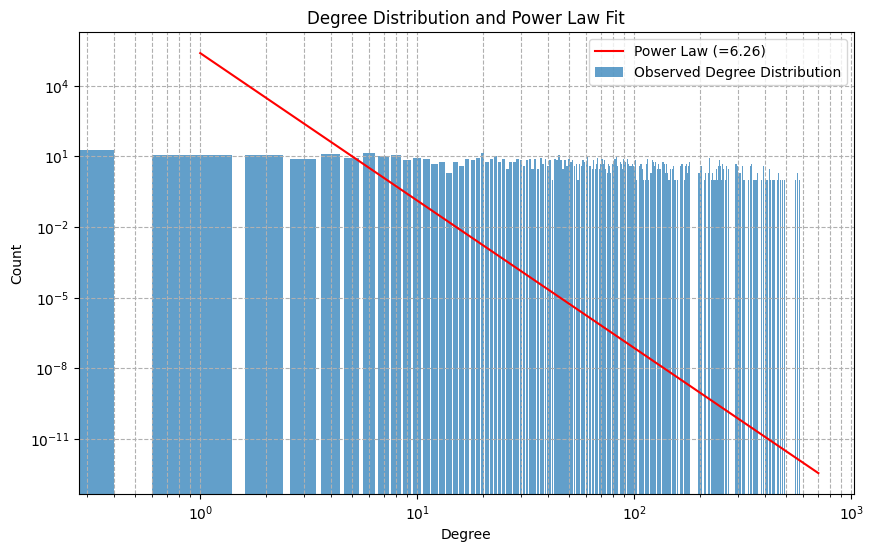

In [33]:
# Plot the degree distribution as a bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(max(l)+1), count, align='center', alpha=0.7, label='Observed Degree Distribution')

# Add the powerlaw function to the plot
# Using the estimated alpha from cell zJlv0nOOyKlH
xmin = xmin # Assuming xmin is 1 based on previous cell
alpha = alpha2 # Using the calculated alpha value
x = np.arange(xmin, max(l) + 1)
# Avoid division by zero for x=0 if xmin is 0
if xmin == 0:
    x = np.arange(1, max(l) + 1)
    powerlaw_y = (x**-alpha) * (len(l) * np.mean(l) / sum(x**-alpha)) # Scale to match sum of degrees
else:
    powerlaw_y = (x**-alpha) * (len(l) * np.mean(l) / sum(x**-alpha)) # Scale to match sum of degrees

# Corrected label string for LaTeX
plt.plot(x, powerlaw_y, 'r-', label=f'Power Law (={alpha:.2f})')

plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Degree Distribution and Power Law Fit')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()